Universidad del Valle de Guatemala <br>
Deep Learning <br>
Sec. 20 <br>
Proyecto Final <br>

Integrantes: <br>
Javier Chávez 21016 <br>
Mario Cristales 21631 <br>
Andres Quezada 21085 <br>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import re


file_path = '/content/drive/My Drive/ColabData/blackjack.csv'
data = pd.read_csv(file_path, nrows=500000)

data.head()


Mounted at /content/drive


,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 11]","[10, 4, 10]",24,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,10,"[5, 5]","[10, 8]",18,"[[5, 5, 11]]",[21],"[['H', 'S']]",-2,0,1.0
2,0,406,6,"[3, 10]","[6, 6, 10]",22,"[[3, 10]]",[13],[['S']],-2,0,1.0
3,0,401,10,"[5, 9]","[10, 8]",18,"[[5, 9, 11, 3]]",[18],"[['H', 'H', 'S']]",-1,0,0.0
4,0,395,8,"[6, 10]","[8, 2, 10]",20,"[[6, 10, 10]]",[26],[['H']],-1,0,-1.0


In [2]:
import numpy as np
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Selection of relevant columns
data = data[['cards_remaining', 'dealer_up', 'initial_hand', 'run_count', 'true_count', 'actions_taken', 'win']]

# 2. Card transformation
def card_value(card):
    if card in ["J", "Q", "K"]:
        return 10
    elif card == "A":
        return 11  # Assume Ace is 11 initially
    else:
        return int(card)

data['dealer_up'] = data['dealer_up'].apply(lambda x: card_value(str(x)))
data['initial_hand'] = data['initial_hand'].apply(lambda x: [card_value(card) for card in eval(x)])
data['initial_card_1'] = data['initial_hand'].apply(lambda x: x[0] if len(x) > 0 else 0)
data['initial_card_2'] = data['initial_hand'].apply(lambda x: x[1] if len(x) > 1 else 0)

# Calculate player's initial hand value
def calculate_hand_value(hand):
    value = sum(hand)
    aces = hand.count(11)
    while value > 21 and aces:
        value -= 10  # Convert an Ace from 11 to 1
        aces -= 1
    return value

data['player_hand_value'] = data['initial_hand'].apply(calculate_hand_value)

# Drop 'initial_hand' as we have extracted necessary information
data.drop(columns=['initial_hand'], inplace=True)

# 3. Action changes counter
action_changes = {
    'Hits changed to Stand': 0,
    'Stands changed to Hit': 0,
    'Doubles changed to Stand': 0,
    'Stands changed to Double': 0,
}

# 4. Function to extract the first action using regex
def extract_first_action(actions):
    actions_str = str(actions)
    match = re.search(r"[A-Z]+", actions_str)  # Find the first action
    return match.group(0) if match else None

# Apply extraction of the first action
data['actions_taken'] = data['actions_taken'].apply(extract_first_action)

# Remove rows with None values in 'actions_taken'
data = data.dropna(subset=['actions_taken'])

# 5. Select 50% of losing hands to modify
losses_mask = data['win'] < 0
loss_indices = data[losses_mask].index
half_loss_indices = np.random.choice(loss_indices, size=len(loss_indices) // 2, replace=False)

# 6. Function to modify actions in losing hands
def modify_action(action):
    if action == 'H':
        action_changes['Hits changed to Stand'] += 1
        return 'S'
    elif action == 'S':
        action_changes['Stands changed to Hit'] += 1
        return 'H'
    elif action == 'D':
        action_changes['Doubles changed to Stand'] += 1
        return 'S'
    elif action == 'S':
        action_changes['Stands changed to Double'] += 1
        return 'D'
    return action

# Apply changes only to the selected 50% of losing hands
data.loc[half_loss_indices, 'actions_taken'] = data.loc[half_loss_indices, 'actions_taken'].apply(modify_action)

# Encode 'actions_taken' after extraction and modification
encoder = LabelEncoder()
data['actions_taken'] = encoder.fit_transform(data['actions_taken'])

# Normalize numerical features
scaler = StandardScaler()
data[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']] = scaler.fit_transform(
    data[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']]
)

# Drop auxiliary columns
data.drop(columns=['win'], inplace=True)

# Display action changes count
print("\nAction changes count:")
for change, count in action_changes.items():
    print(f"{change}: {count}")

# Display action mapping
print("\nAction mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

# Display head of the dataframe
data.head()



Action changes count:
Hits changed to Stand: 46112
Stands changed to Hit: 36524
Doubles changed to Stand: 9366
Stands changed to Double: 0

Action mapping: {'D': 0, 'H': 1, 'N': 2, 'P': 3, 'R': 4, 'S': 5}


,cards_remaining,dealer_up,run_count,true_count,actions_taken,initial_card_1,initial_card_2,player_hand_value
0,1.702052,10,0.104190,-0.019092,5,10,11,1.574949
1,1.651173,10,-0.275107,-0.019092,1,5,5,-1.115650
2,1.600293,6,-0.275107,-0.019092,5,3,10,-0.381850
3,1.549414,10,-0.148675,-0.019092,1,5,9,-0.137250
4,1.488358,8,-0.148675,-0.019092,1,6,10,0.351949


In [3]:
# Imprimir el mapeo de clases para 'actions_taken'
action_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Mapping de acciones:", action_mapping)


Mapping de acciones: {'D': 0, 'H': 1, 'N': 2, 'P': 3, 'R': 4, 'S': 5}


In [4]:
# Separate features (X) and labels (y)
X = data[['cards_remaining', 'dealer_up', 'initial_card_1', 'initial_card_2', 'run_count', 'true_count', 'player_hand_value']].values
y = data['actions_taken'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the MLP model
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo MLP
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')  # Usamos softmax para salida de clasificación
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7266 - loss: 0.6412 - val_accuracy: 0.7982 - val_loss: 0.4454
Epoch 2/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.7991 - loss: 0.4428 - val_accuracy: 0.8039 - val_loss: 0.4414
Epoch 3/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.8051 - loss: 0.4334 - val_accuracy: 0.7828 - val_loss: 0.4978
Epoch 4/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.8078 - loss: 0.4274 - val_accuracy: 0.8114 - val_loss: 0.4210
Epoch 5/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8097 - loss: 0.4234 - val_accuracy: 0.8101 - val_loss: 0.4229
Epoch 6/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.8099 - loss: 0.4229 - val_accuracy: 0.8108 - val_loss: 0.4188
Epoch 7/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.8099 - loss: 0.4215 - val_accuracy: 0.8096 - val_loss: 0.4215
Epoch 8/20
12207/12207 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 

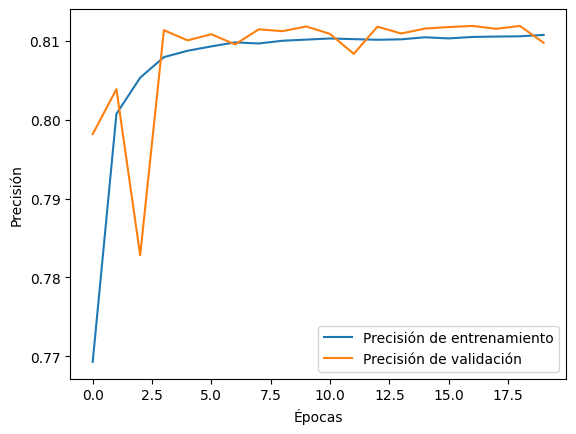

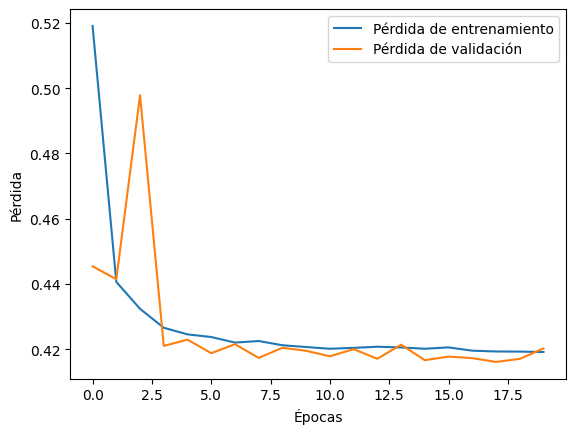

In [5]:
import matplotlib.pyplot as plt

# Graficar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [6]:
# Evaluación en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_accuracy:.2f}')


3052/3052 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8095 - loss: 0.4211
Precisión en el conjunto de prueba: 0.81


In [7]:
import numpy as np
import random
import pandas as pd

# Values of the cards
card_values_dict = {
    '2': 2, '3': 3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10,
    'J':10, 'Q':10, 'K':10, 'A':11  # Ace can be 11 or 1; we'll handle this later
}

# Function to create a deck of cards
def create_deck(num_decks=6):
    deck = []
    for _ in range(num_decks):  # Using multiple decks
        for card in card_values_dict.keys():
            deck.extend([card]*4)
    random.shuffle(deck)
    return deck

# Function to calculate the value of a hand
def calculate_hand_value(hand):
    value = 0
    aces = 0
    for card in hand:
        card_value = card_values_dict[card]
        value += card_value
        if card == 'A':
            aces += 1
    # Adjust for Aces
    while value > 21 and aces:
        value -= 10
        aces -= 1
    return value

# Function to deal a card
def deal_card(deck):
    if len(deck) == 0:
        # If the deck is empty, reshuffle
        deck.extend(create_deck())
    return deck.pop()

# Function to check if a hand busts
def is_bust(hand):
    return calculate_hand_value(hand) > 21

# Dealer's play according to standard rules
def dealer_play(deck, dealer_hand):
    while calculate_hand_value(dealer_hand) < 17:
        dealer_hand.append(deal_card(deck))
    return dealer_hand

# Function to convert cards to numerical values for the model
def card_to_model_value(card):
    if card in ["J", "Q", "K"]:
        return 10
    elif card == "A":
        return 11
    else:
        return int(card)

def is_blackjack(hand):
    return calculate_hand_value(hand) == 21 and len(hand) == 2


def simulate_game(model, scaler, encoder, deck, run_count, true_count, num_decks=6):
    # Verificar si se debe rebarajar el mazo
    if len(deck) < (num_decks * 52) * 0.25:
        deck.clear()
        deck.extend(create_deck(num_decks))
        run_count = 0  # Reiniciar el conteo
        random.shuffle(deck)

    # Manos iniciales
    player_hand = [deal_card(deck), deal_card(deck)]
    dealer_hand = [deal_card(deck), deal_card(deck)]

    # Verificar si el jugador tiene Blackjack
    initial_player_value = calculate_hand_value(player_hand)
    is_player_blackjack = is_blackjack(player_hand)

    # Inicializar variables
    player_turn = True
    player_actions = []
    bet_multiplier = 1  # Para manejar dobles y splits

    while player_turn and not is_player_blackjack:
        # Obtener características actuales para el modelo
        cards_remaining = len(deck)
        dealer_up_card = card_to_model_value(dealer_hand[0])  # Carta visible del crupier
        initial_card_1 = card_to_model_value(player_hand[0])
        initial_card_2 = card_to_model_value(player_hand[1]) if len(player_hand) > 1 else 0
        run_count = 0  # Implementar conteo si se desea
        true_count = 0  # Igual que arriba
        player_hand_value = calculate_hand_value(player_hand)

        # Crear un DataFrame para las características
        features = pd.DataFrame({
            'cards_remaining': [cards_remaining],
            'dealer_up': [dealer_up_card],
            'initial_card_1': [initial_card_1],
            'initial_card_2': [initial_card_2],
            'run_count': [run_count],
            'true_count': [true_count],
            'player_hand_value': [player_hand_value]
        })

        # Normalizar las características correspondientes
        features[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']] = scaler.transform(
            features[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']]
        )

        # Convertir las características a un arreglo NumPy
        features_array = features.values

        # Predecir acción
        prediction = model.predict(features_array)
        predicted_action = np.argmax(prediction, axis=1)
        action = encoder.inverse_transform(predicted_action)[0]

        player_actions.append(action)

        if action == 'H':
            # Hit: Repartir una carta
            player_hand.append(deal_card(deck))
            # Verificar si el jugador se pasa
            if is_bust(player_hand):
                player_turn = False
        elif action == 'S':
            # Stand: Terminar turno del jugador
            player_turn = False
        elif action == 'D':
            # Double: El jugador duplica apuesta, recibe una carta y se planta
            player_hand.append(deal_card(deck))
            bet_multiplier = 2  # Actualizar el multiplicador de apuesta
            # Verificar si el jugador se pasa
            if is_bust(player_hand):
                pass  # El jugador pierde
            player_turn = False
        else:
            # Cualquier otra acción se trata como Stand
            player_turn = False

    # Verificar si el jugador se pasó
    if is_bust(player_hand):
        return 'loss', player_actions, player_hand, dealer_hand, deck, run_count, true_count, bet_multiplier

    # Turno del crupier
    dealer_hand = dealer_play(deck, dealer_hand)

    # Determinar resultado
    player_value = calculate_hand_value(player_hand)
    dealer_value = calculate_hand_value(dealer_hand)

    if is_bust(dealer_hand):
        result = 'win'
    elif player_value > dealer_value:
        result = 'win'
    elif player_value < dealer_value:
        result = 'loss'
    else:
        result = 'draw'

    return result, player_actions, player_hand, dealer_hand, deck, run_count, true_count, bet_multiplier




In [8]:
# Initialize deck, run_count, and true_count
num_decks = 6
deck = create_deck(num_decks)
run_count = 0  # Implement count if desired
true_count = 0

# Simulate multiple games
num_games = 1000
results = {'win': 0, 'loss': 0, 'draw': 0}
action_counts = []

for _ in range(num_games):
    result, player_actions, player_hand, dealer_hand, deck, run_count, true_count = simulate_game(
        model, scaler, encoder, deck, run_count, true_count, num_decks=num_decks)
    results[result] += 1
    action_counts.append(len(player_actions))

# Calculate action statistics
total_actions = sum(action_counts)
average_actions_per_game = total_actions / num_games
max_actions = max(action_counts)
min_actions = min(action_counts)

# Display results
print(f"Out of {num_games} games:")
print(f"Wins: {results['win']}")
print(f"Losses: {results['loss']}")
print(f"Draws: {results['draw']}")
print(f"Win rate: {results['win']/num_games * 100:.2f}%")
print(f"Total actions: {total_actions}")
print(f"Average actions per game: {average_actions_per_game:.2f}")
print(f"Max actions in a game: {max_actions}")
print(f"Min actions in a game: {min_actions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


ValueError: too many values to unpack (expected 7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

=== Juego 1 ===
Mano inicial del jugador:
┌─────────┐ ┌─────────┐
│ 2       │ │ 3       │
│         │ │         │
│    ♥    │ │    ♥    │
│         │ │         │
│       2 │ │       3 │
└─────────┘ └─────────┘
(Valor: 5)
Carta visible del crupier:
┌─────────┐
│ A       │
│         │
│    ♠    │
│         │
│       A │
└─────────┘
(Valor: 11)
Acciones tomadas por el jugador:
  Acción 1: N
Mano final del jugador:
┌─────────┐ ┌─────────┐
│ 2       │ │ 3       │
│         │ │         │
│    ♥    │ │    ♥    │
│         │ │         │
│       2 │ │       3 │
└─────────┘ └─────────┘
(Valor: 5)
Mano del crupier:
┌─────────┐ ┌─────────┐ ┌─────────┐ ┌─────────┐
│ A       │ │ 3       │ │ 9       │ │ J       │
│         │ │         │ │         │ │         │
│    ♠    │ │    ♠    │ │    ♠    │ │    ♠    │
│         │ │         │ │         │ │         │
│       A │ │       3 │ │       9 │ │       J │
└─────────┘ └─────────┘ └─────────┘ └─────────┘
(Valor: 23)
R

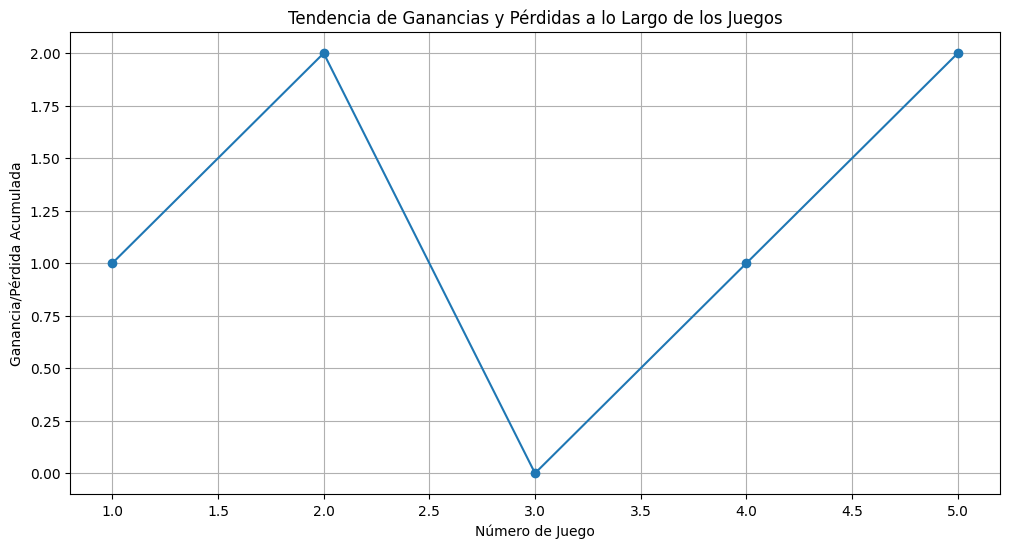

In [9]:
import matplotlib.pyplot as plt

# Definir los símbolos de los palos
suit_symbols = {
    'hearts': '♥',
    'diamonds': '♦',
    'clubs': '♣',
    'spades': '♠'
}

def get_card_ascii(card_value, suit_symbol):
    top_line = "┌─────────┐"
    empty_line = "│         │"
    middle_line = f"│    {suit_symbol}    │"
    value_line_top = f"│ {card_value:<2}      │"
    value_line_bottom = f"│      {card_value:>2} │"
    bottom_line = "└─────────┘"
    card_lines = [
        top_line,
        value_line_top,
        empty_line,
        middle_line,
        empty_line,
        value_line_bottom,
        bottom_line
    ]
    return card_lines

def display_hand_ascii(hand, suits):
    card_ascii_list = []
    for card_value, suit_symbol in zip(hand, suits):
        card_ascii = get_card_ascii(card_value, suit_symbol)
        card_ascii_list.append(card_ascii)

    # Combinar las líneas de cada carta para mostrar lado a lado
    for lines in zip(*card_ascii_list):
        print(" ".join(lines))


# Inicializar el deck, run_count y true_count
num_decks = 6
deck = create_deck(num_decks)
run_count = 0
true_count = 0

# Simular un número reducido de juegos para análisis detallado
num_games = 5  # Ajusta este número según tus necesidades
results = {'win': 0, 'loss': 0, 'draw': 0}
profit_loss = []
cumulative_profit_loss = []
cumulative_total = 0

for game_number in range(1, num_games + 1):
    result, player_actions, player_hand, dealer_hand, deck, run_count, true_count, bet_multiplier = simulate_game(
        model, scaler, encoder, deck, run_count, true_count, num_decks=num_decks)
    results[result] += 1

    # Calcular la ganancia/pérdida del juego
    if result == 'win':
        gain = 1 * bet_multiplier
        if is_blackjack(player_hand):
            gain = 1.5
    elif result == 'loss':
        gain = -1 * bet_multiplier
    else:
        gain = 0

    cumulative_total += gain
    profit_loss.append(gain)
    cumulative_profit_loss.append(cumulative_total)

    # Mostrar detalles del juego con cartas en ASCII
    print(f"\n=== Juego {game_number} ===")
    print(f"Mano inicial del jugador:")
    player_initial_hand = player_hand[:2]
    player_suits = ['♥', '♥']  # Puedes asignar palos aleatorios
    display_hand_ascii(player_initial_hand, player_suits)
    print(f"(Valor: {calculate_hand_value(player_initial_hand)})")

    print(f"Carta visible del crupier:")
    dealer_visible_card = [dealer_hand[0]]
    dealer_suits = ['♠']
    display_hand_ascii(dealer_visible_card, dealer_suits)
    print(f"(Valor: {card_values_dict[dealer_hand[0]]})")

    print("Acciones tomadas por el jugador:")
    for idx, action in enumerate(player_actions):
        print(f"  Acción {idx + 1}: {action}")
        if idx < len(player_hand) - 2:
            new_card = player_hand[2 + idx]
            print(f"    Carta añadida:")
            display_hand_ascii([new_card], ['♦'])
            print(f"    Mano actual del jugador:")
            current_hand = player_hand[:3 + idx]
            current_suits = ['♥'] * len(current_hand)
            display_hand_ascii(current_hand, current_suits)
            print(f"    (Valor: {calculate_hand_value(current_hand)})")

    # Mostrar la mano final del jugador y del crupier
    player_final_value = calculate_hand_value(player_hand)
    dealer_final_value = calculate_hand_value(dealer_hand)

    print(f"Mano final del jugador:")
    player_suits = ['♥'] * len(player_hand)
    display_hand_ascii(player_hand, player_suits)
    print(f"(Valor: {player_final_value})")

    print(f"Mano del crupier:")
    dealer_suits = ['♠'] * len(dealer_hand)
    display_hand_ascii(dealer_hand, dealer_suits)
    print(f"(Valor: {dealer_final_value})")

    print(f"Resultado del juego: {result.upper()}")
    print(f"Ganancia/Pérdida de este juego: {gain}")

# Mostrar resultados totales y graficar tendencia
print(f"\nResultados totales de {num_games} juegos:")
print(f"Victorias: {results['win']}")
print(f"Derrotas: {results['loss']}")
print(f"Empates: {results['draw']}")
print(f"Ganancia/Pérdida total: {cumulative_total}")

# Graficar la tendencia de ganancias y pérdidas
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_games + 1), cumulative_profit_loss, marker='o')
plt.title('Tendencia de Ganancias y Pérdidas a lo Largo de los Juegos')
plt.xlabel('Número de Juego')
plt.ylabel('Ganancia/Pérdida Acumulada')
plt.grid(True)
plt.show()


In [10]:

# Diccionario de valores de cartas
card_values_dict = {
    '2': 2, '3': 3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10,
    'J':10, 'Q':10, 'K':10, 'A':11
}

# Definir los símbolos de los palos
suit_symbols = {
    'hearts': '♥',
    'diamonds': '♦',
    'clubs': '♣',
    'spades': '♠'
}

# Función para calcular el valor de una mano
def calculate_hand_value(hand):
    value = 0
    aces = 0
    for card in hand:
        card_value = card_values_dict.get(card, 0)
        value += card_value
        if card == 'A':
            aces += 1
    # Ajustar por ases
    while value > 21 and aces:
        value -= 10
        aces -= 1
    return value

# Función para convertir cartas a valores numéricos para el modelo
def card_to_model_value(card):
    if card in ["J", "Q", "K"]:
        return 10
    elif card == "A":
        return 11
    else:
        return int(card)

# Función para solicitar y validar la entrada de cartas
def get_valid_card(prompt):
    while True:
        card = input(prompt).strip().upper()
        if card in card_values_dict:
            return card
        else:
            print("Carta inválida. Por favor, ingresa una carta válida (2-10, J, Q, K, A).")

# Funciones para mostrar cartas en ASCII
def get_card_ascii(card_value, suit_symbol):
    top_line = "┌─────────┐"
    empty_line = "│         │"
    middle_line = f"│    {suit_symbol}    │"
    value_line_top = f"│ {card_value:<2}      │"
    value_line_bottom = f"│      {card_value:>2} │"
    bottom_line = "└─────────┘"
    card_lines = [
        top_line,
        value_line_top,
        empty_line,
        middle_line,
        empty_line,
        value_line_bottom,
        bottom_line
    ]
    return card_lines

def display_hand_ascii(hand, suits):
    card_ascii_list = []
    for card_value, suit_symbol in zip(hand, suits):
        card_ascii = get_card_ascii(card_value, suit_symbol)
        card_ascii_list.append(card_ascii)
    # Combinar las líneas de cada carta para mostrar lado a lado
    for lines in zip(*card_ascii_list):
        print(" ".join(lines))

# Función principal para simular el juego interactivo
def interactive_blackjack(model, scaler, encoder):
    print("¡Bienvenido al Asesor de Blackjack AI!")
    print("Ingresa tus dos cartas y la carta visible del crupier.")

    # Obtener las cartas del jugador y del crupier
    player_card1 = get_valid_card("Ingresa tu primera carta: ")
    player_card2 = get_valid_card("Ingresa tu segunda carta: ")
    dealer_up_card = get_valid_card("Ingresa la carta visible del crupier: ")

    # Inicializar manos
    player_hand = [player_card1, player_card2]
    dealer_hand = [dealer_up_card]

    # Variables iniciales
    player_turn = True
    player_actions = []
    run_count = 0
    true_count = 0
    num_decks = 6
    cards_remaining = num_decks * 52

    # Mostrar la mano inicial del jugador y la carta del crupier
    player_hand_value = calculate_hand_value(player_hand)
    print("\nTu mano:")
    player_suits = ['♥', '♦']  # Puedes asignar palos aleatorios o específicos
    display_hand_ascii(player_hand, player_suits)
    print(f"(Valor: {player_hand_value})")

    print(f"\nCarta visible del crupier:")
    dealer_suits = ['♠']
    display_hand_ascii([dealer_up_card], dealer_suits)
    print(f"(Valor: {card_values_dict[dealer_up_card]})")

    # Verificar si el jugador tiene Blackjack
    if player_hand_value == 21 and len(player_hand) == 2:
        print("¡Blackjack! Tienes 21.")
        player_turn = False
        result = 'blackjack'
    else:
        # Simulación del turno del jugador
        while player_turn:
            # Verificar si el jugador se ha pasado
            if player_hand_value > 21:
                print("¡Te has pasado de 21!")
                break

            # Preparar características para el modelo
            initial_card_1 = card_to_model_value(player_hand[0])
            initial_card_2 = card_to_model_value(player_hand[1]) if len(player_hand) > 1 else 0
            dealer_up_value = card_to_model_value(dealer_up_card)

            features = pd.DataFrame({
                'cards_remaining': [cards_remaining],
                'dealer_up': [dealer_up_value],
                'initial_card_1': [initial_card_1],
                'initial_card_2': [initial_card_2],
                'run_count': [run_count],
                'true_count': [true_count],
                'player_hand_value': [player_hand_value]
            })

            # Normalizar las características correspondientes
            features[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']] = scaler.transform(
                features[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']]
            )

            # Predecir acción
            prediction = model.predict(features.values)
            predicted_action = np.argmax(prediction, axis=1)
            action = encoder.inverse_transform(predicted_action)[0]

            print(f"\nEl modelo recomienda: {action}")
            player_actions.append(action)

            if action == 'S':
                print("Te has plantado.")
                player_turn = False
            elif action == 'H':
                # Hit: El jugador pide una carta
                new_card = get_valid_card("El modelo recomienda pedir una carta. Ingresa la carta que recibiste: ")
                player_hand.append(new_card)
                player_hand_value = calculate_hand_value(player_hand)
                # Mostrar la nueva mano
                print("\nTu nueva mano:")
                player_suits.append('♣')  # Puedes asignar un palo específico
                display_hand_ascii(player_hand, player_suits)
                print(f"(Valor: {player_hand_value})")
                # Continuar el bucle
            elif action == 'D':
                # Double: El jugador duplica apuesta, recibe una carta y se planta
                new_card = get_valid_card("El modelo recomienda doblar. Ingresa la carta que recibiste al doblar: ")
                player_hand.append(new_card)
                player_hand_value = calculate_hand_value(player_hand)
                print("Has doblado tu apuesta.")
                # Mostrar la nueva mano
                print("\nTu nueva mano después de doblar:")
                player_suits.append('♣')
                display_hand_ascii(player_hand, player_suits)
                print(f"(Valor: {player_hand_value})")
                player_turn = False
            else:
                # Cualquier otra acción se trata como Stand
                print("Te has plantado.")
                player_turn = False

            # Verificar si el jugador se ha pasado después de recibir la nueva carta
            if player_hand_value > 21:
                print("¡Te has pasado de 21!")
                player_turn = False
            elif player_hand_value == 21:
                print("¡Tienes 21!")
                player_turn = False

    # Mostrar resultado final del jugador
    player_hand_value = calculate_hand_value(player_hand)
    if player_hand_value > 21:
        print(f"Te has pasado con un valor de mano de {player_hand_value}.")
        result = 'loss'
    elif player_hand_value == 21 and len(player_hand) == 2:
        print("¡Blackjack! Tienes 21.")
        result = 'blackjack'
    else:
        print("\nFin de tu turno.")
        print("Tu mano final:")
        display_hand_ascii(player_hand, player_suits)
        print(f"(Valor: {player_hand_value})")
        result = 'stand'

    # Mostrar acciones tomadas
    print("\nJuego terminado.")
    print(f"Tu mano final: {player_hand} (Valor: {player_hand_value})")
    print(f"Acciones tomadas: {player_actions}")

# Ejecutar el juego interactivo
interactive_blackjack(model, scaler, encoder)


¡Bienvenido al Asesor de Blackjack AI!
Ingresa tus dos cartas y la carta visible del crupier.
Ingresa tu primera carta: 3
Ingresa tu segunda carta: 7
Ingresa la carta visible del crupier: A

Tu mano:
┌─────────┐ ┌─────────┐
│ 3       │ │ 7       │
│         │ │         │
│    ♥    │ │    ♦    │
│         │ │         │
│       3 │ │       7 │
└─────────┘ └─────────┘
(Valor: 10)

Carta visible del crupier:
┌─────────┐
│ A       │
│         │
│    ♠    │
│         │
│       A │
└─────────┘
(Valor: 11)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

El modelo recomienda: N
Te has plantado.

Fin de tu turno.
Tu mano final:
┌─────────┐ ┌─────────┐
│ 3       │ │ 7       │
│         │ │         │
│    ♥    │ │    ♦    │
│         │ │         │
│       3 │ │       7 │
└─────────┘ └─────────┘
(Valor: 10)

Juego terminado.
Tu mano final: ['3', '7'] (Valor: 10)
Acciones tomadas: ['N']


## Análisis de Resultados

3052/3052 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


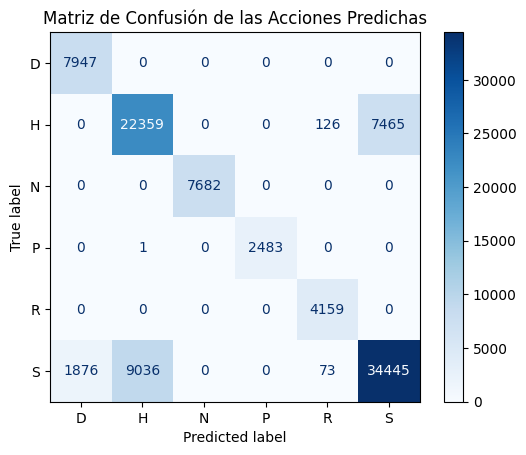

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generar predicciones en el conjunto de prueba
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener los nombres de las clases del encoder
class_names = encoder.classes_

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión de las Acciones Predichas')
plt.show()


In [12]:
from sklearn.metrics import classification_report

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=class_names))


Reporte de Clasificación:
              precision    recall  f1-score   support

           D       0.81      1.00      0.89      7947
           H       0.71      0.75      0.73     29950
           N       1.00      1.00      1.00      7682
           P       1.00      1.00      1.00      2484
           R       0.95      1.00      0.98      4159
           S       0.82      0.76      0.79     45430

    accuracy                           0.81     97652
   macro avg       0.88      0.92      0.90     97652
weighted avg       0.81      0.81      0.81     97652



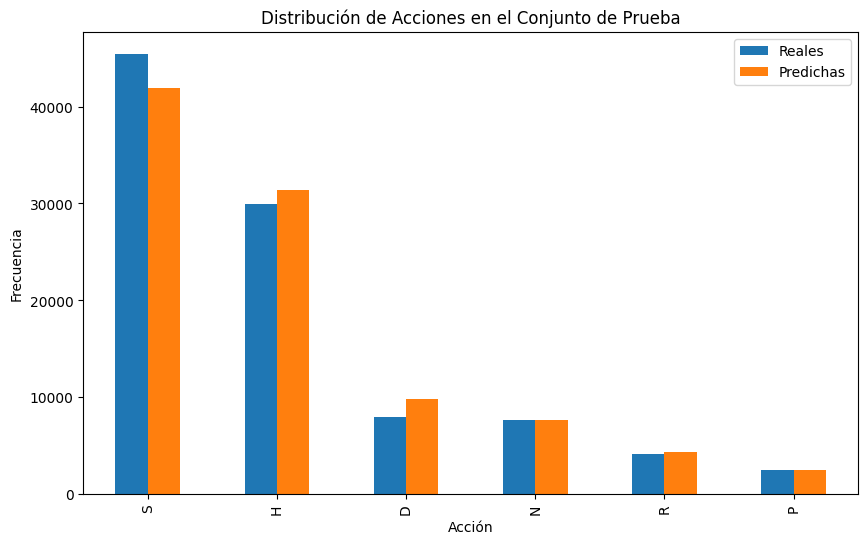

In [13]:
import seaborn as sns

# Conteo de acciones reales
actual_action_counts = pd.Series(y_test).map(lambda x: class_names[x]).value_counts()
# Conteo de acciones predichas
predicted_action_counts = pd.Series(y_pred).map(lambda x: class_names[x]).value_counts()

# Crear un DataFrame para graficar
action_distribution = pd.DataFrame({
    'Reales': actual_action_counts,
    'Predichas': predicted_action_counts
})

# Graficar la distribución
action_distribution.plot(kind='bar', figsize=(10,6))
plt.title('Distribución de Acciones en el Conjunto de Prueba')
plt.xlabel('Acción')
plt.ylabel('Frecuencia')
plt.show()


Precisión de la estrategia básica en el conjunto de prueba: 0.53


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

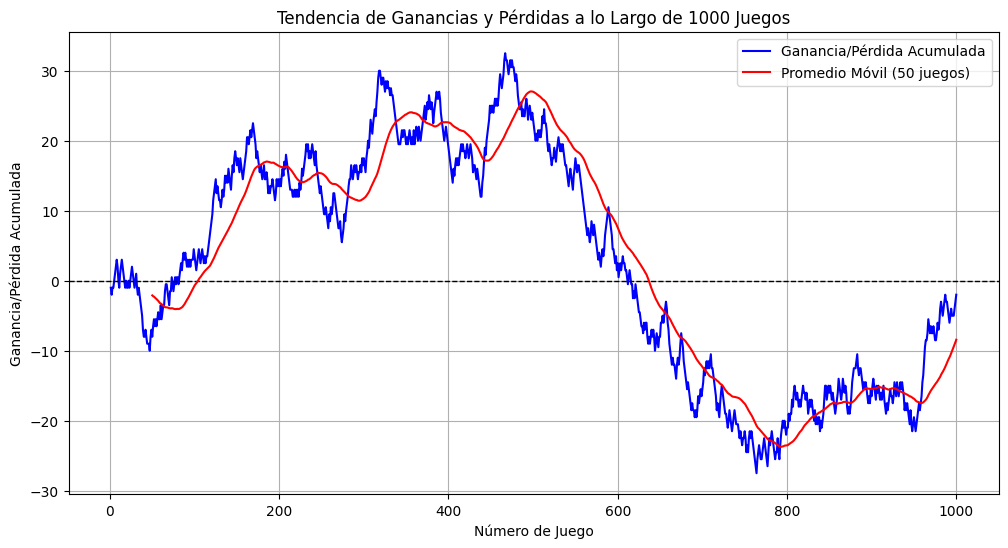

In [25]:
# Inicializar el deck, run_count y true_count
num_decks = 6
deck = create_deck(num_decks)
run_count = 0
true_count = 0

# Simular 1000 juegos
num_games = 1000
results = {'win': 0, 'loss': 0, 'draw': 0}
profit_loss = []
cumulative_profit_loss = []
cumulative_total = 0

for game_number in range(1, num_games + 1):
    result, player_actions, player_hand, dealer_hand, deck, run_count, true_count, bet_multiplier = simulate_game(
        model, scaler, encoder, deck, run_count, true_count, num_decks=num_decks)
    results[result] += 1

    # Calcular la ganancia/pérdida del juego
    if result == 'win':
        gain = 1 * bet_multiplier
        if is_blackjack(player_hand):
            gain = 1.5 * bet_multiplier  # Ajustar si se aplica el multiplicador
    elif result == 'loss':
        gain = -1 * bet_multiplier
    else:
        gain = 0  # Para empates

    cumulative_total += gain
    profit_loss.append(gain)
    cumulative_profit_loss.append(cumulative_total)

# Mostrar resultados totales
print(f"\nResultados totales de {num_games} juegos:")
print(f"Victorias: {results['win']}")
print(f"Derrotas: {results['loss']}")
print(f"Empates: {results['draw']}")
print(f"Ganancia/Pérdida total: {cumulative_total}")
print(f"Tasa de victoria: {results['win']/num_games * 100:.2f}%")

# Graficar la tendencia de ganancias y pérdidas
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_games + 1), cumulative_profit_loss, label='Ganancia/Pérdida Acumulada', color='blue')
plt.title('Tendencia de Ganancias y Pérdidas a lo Largo de 1000 Juegos')
plt.xlabel('Número de Juego')
plt.ylabel('Ganancia/Pérdida Acumulada')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.legend()

# Calcular el promedio móvil para suavizar la curva
window_size = 50
moving_average = pd.Series(cumulative_profit_loss).rolling(window=window_size).mean()
plt.plot(range(1, num_games + 1), moving_average, color='red', label=f'Promedio Móvil ({window_size} juegos)')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

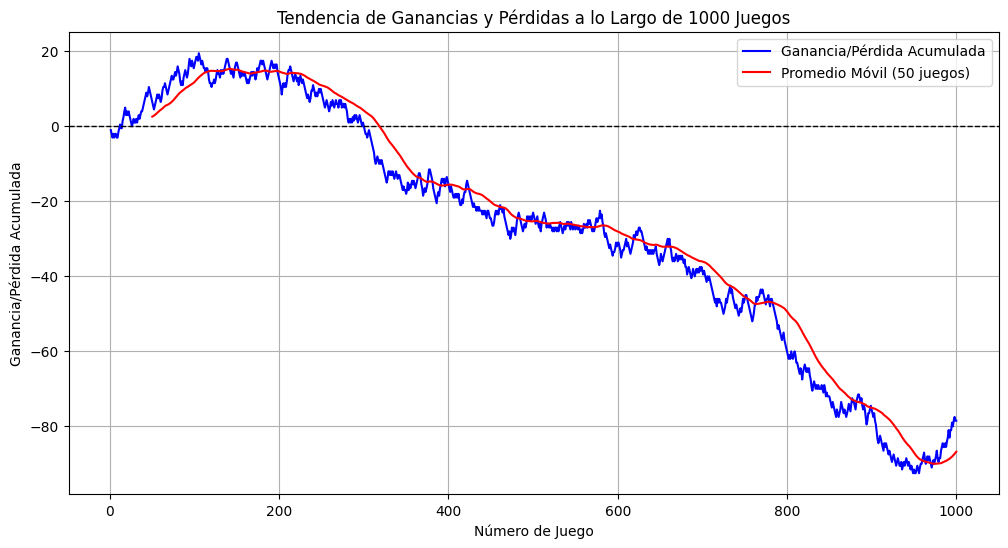

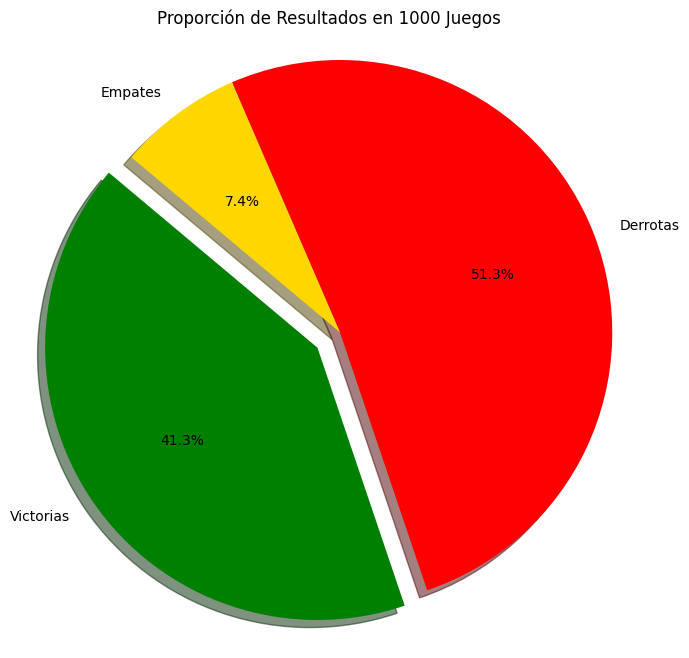

In [21]:
# Importar las librerías necesarias
import matplotlib.pyplot as plt
import pandas as pd

# Inicializar el deck, run_count y true_count
num_decks = 6
deck = create_deck(num_decks)
run_count = 0
true_count = 0

# Simular 1000 juegos
num_games = 1000
results = {'win': 0, 'loss': 0, 'draw': 0}
profit_loss = []
cumulative_profit_loss = []
cumulative_total = 0

for game_number in range(1, num_games + 1):
    result, player_actions, player_hand, dealer_hand, deck, run_count, true_count, bet_multiplier = simulate_game(
        model, scaler, encoder, deck, run_count, true_count, num_decks=num_decks)
    results[result] += 1

    # Calcular la ganancia/pérdida del juego
    if result == 'win':
        gain = 1 * bet_multiplier
        if is_blackjack(player_hand):
            gain = 1.5 * bet_multiplier
    elif result == 'loss':
        gain = -1 * bet_multiplier
    else:
        gain = 0  # Para empates

    cumulative_total += gain
    profit_loss.append(gain)
    cumulative_profit_loss.append(cumulative_total)

# Mostrar resultados totales
print(f"\nResultados totales de {num_games} juegos:")
print(f"Victorias: {results['win']}")
print(f"Derrotas: {results['loss']}")
print(f"Empates: {results['draw']}")
print(f"Ganancia/Pérdida total: {cumulative_total}")
print(f"Tasa de victoria: {results['win']/num_games * 100:.2f}%")

# Graficar la tendencia de ganancias y pérdidas
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_games + 1), cumulative_profit_loss, label='Ganancia/Pérdida Acumulada', color='blue')
plt.title('Tendencia de Ganancias y Pérdidas a lo Largo de 1000 Juegos')
plt.xlabel('Número de Juego')
plt.ylabel('Ganancia/Pérdida Acumulada')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.legend()

# Calcular el promedio móvil para suavizar la curva
window_size = 50
moving_average = pd.Series(cumulative_profit_loss).rolling(window=window_size).mean()
plt.plot(range(1, num_games + 1), moving_average, color='red', label=f'Promedio Móvil ({window_size} juegos)')
plt.legend()
plt.show()

# Crear una gráfica de pastel para visualizar las proporciones de resultados
labels = ['Victorias', 'Derrotas', 'Empates']
sizes = [results['win'], results['loss'], results['draw']]
colors = ['green', 'red', 'gold']
explode = (0.1, 0, 0)  # Destacar la porción de victorias

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Proporción de Resultados en 1000 Juegos')
plt.axis('equal')  # Para asegurar que el gráfico sea circular
plt.show()
